In [1]:
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader

from dataset import BlobsDataset


from PIL import Image
import io

from utils import display_video
from IPython.display import clear_output

from models.modules import FC_vec
from models.fm import FlowBasedModels
import copy

device = 'cuda:0'

In [2]:
ds = BlobsDataset(
    n_samples_per_cluster=250,
    n_clusters=4,
    radius=5,
    cluster_std=0.6,
)
data_loader = DataLoader(dataset=ds, batch_size=64, shuffle=True)


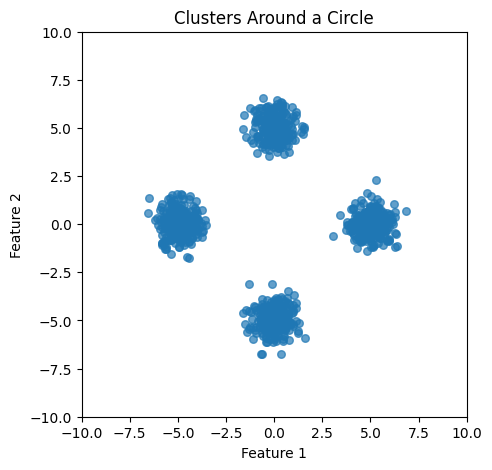

In [3]:
# Visualize the blobs
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ds.add_blobs(ax)
ax.set_title("Clusters Around a Circle")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_aspect('equal')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
plt.show()

In [4]:
velocity = FC_vec(
    in_chan=2+1,
    out_chan=2,
    l_hidden=[1024, 1024],
    activation=['gelu', 'gelu'],
    out_activation='linear',
)
model = FlowBasedModels(velocity, sigma_min=0.01)
model.to(device);

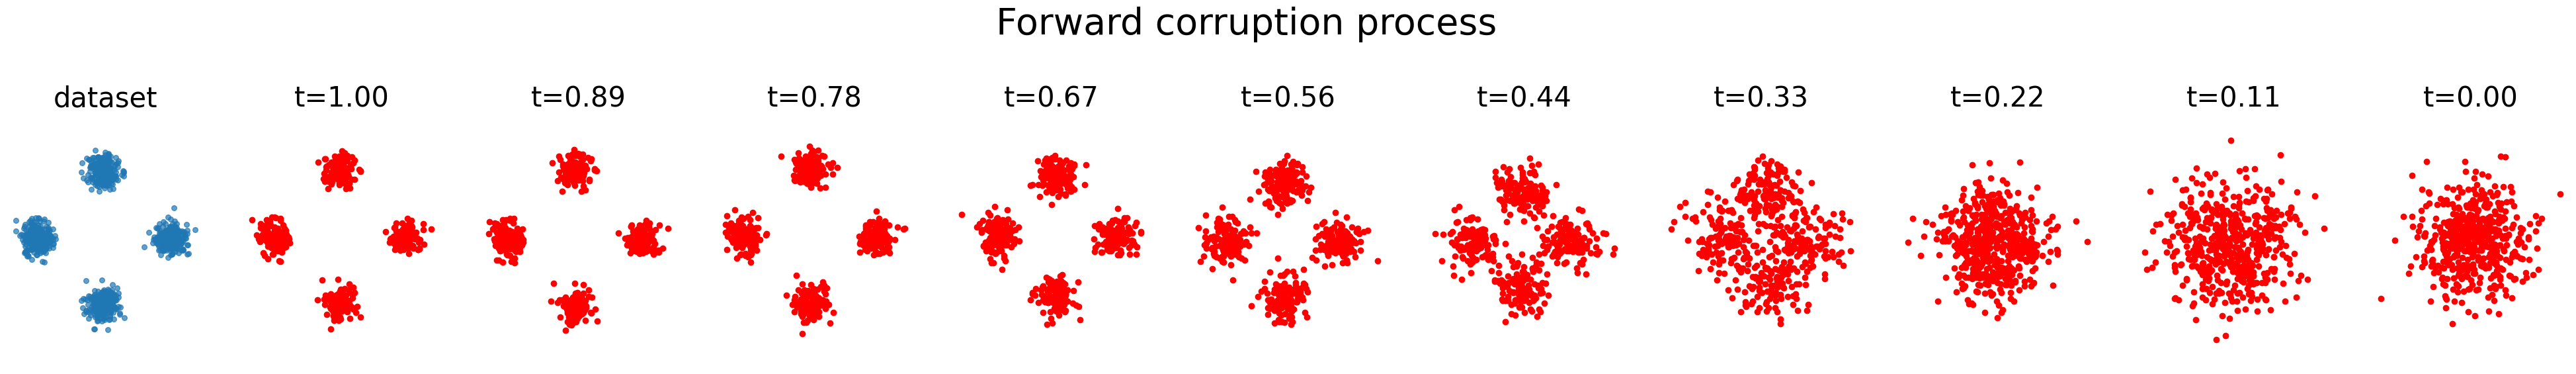

In [5]:
# Visualize the blobs
x0 = ds.X[:500].to(device)

n_time = 10 
fig, axs = plt.subplots(1, n_time + 1, figsize=(5*n_time, 5))
ds.add_blobs(axs[0])
axs[0].axis('off')
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(-10, 10)
axs[0].set_title(f'dataset', fontsize=30)
axs[0].axis('equal')

for i, t in enumerate(torch.linspace(1, 0, n_time)):
    x = model.corruption_process(x0, t).detach().cpu()
    axs[i+1].scatter(x[:, 0], x[:, 1], color='red', label='*')
    axs[i+1].set_xlim(-10, 10)
    axs[i+1].set_ylim(-10, 10)
    axs[i+1].axis('equal')
    axs[i+1].axis('off')
    axs[i+1].set_title(f't={t:.2f}', fontsize=30)
plt.suptitle('Forward corruption process', fontsize=40, y=1.2)
plt.show()

In [6]:
x0 = ds.X[:500].to(device)

n_time = 100
video = []
for i, t in enumerate(torch.linspace(1, 0, n_time)):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = model.corruption_process(x0, t).detach().cpu()
    ax.scatter(x[:, 0], x[:, 1], color='red', label='*')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(f't={t:.2f}', fontsize=30)

    # Save the figure to a buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')  # Save to a buffer as a PNG image
    buf.seek(0)  # Rewind the buffer

    # Load the buffer into a PIL image and convert to NumPy array
    image = Image.open(buf)
    image_array = np.array(image)  # Convert to a NumPy array
    buf.close()  # Close the buffer
    plt.close()
    
    video.append(image_array)

In [7]:
display_video(video, framerate=20)    

Epoch: 1500, Loss: 4.9226056933403015


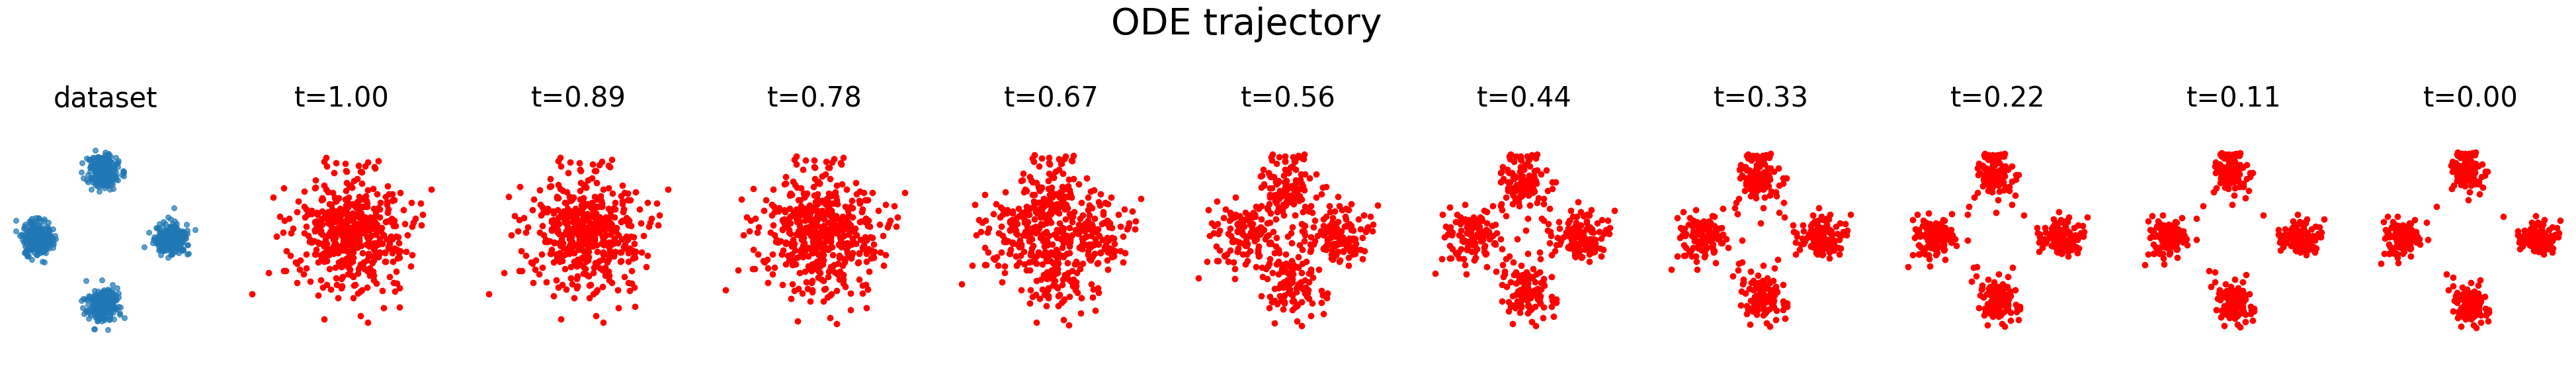

In [8]:
velocity = FC_vec(
    in_chan=2+1,
    out_chan=2,
    l_hidden=[1024, 1024],
    activation=['gelu', 'gelu'],
    out_activation='linear',
)
model = FlowBasedModels(velocity, sigma_min=0.01)

load_pretraiend = False
if load_pretraiend:
    model.load_state_dict(torch.load('results/vel_model.pth', map_location='cpu'))
model.to(device);

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

if load_pretraiend:
    total_epoch = 0
else:
    total_epoch = 2000
    
for epoch in range(total_epoch):
    mean_loss = []
    for x1, _ in data_loader:
        train_results = model.train_step(x1.to(device), optimizer)
        mean_loss.append(train_results['loss'])
    mean_loss = sum(mean_loss)/len(mean_loss)
    lr_scheduler.step()
    
    if epoch % 500 == 0:
        clear_output(wait=True)
        print(f"Epoch: {epoch}, Loss: {mean_loss}")
        x0 = torch.randn(500, 2).to(device)
        xt, xtraj = model.solve_ode(x0, dt=0.01)

        # Visualize the blobs
        n_time = 10 
        fig, axs = plt.subplots(1, n_time + 1, figsize=(5*n_time, 5))
        ds.add_blobs(axs[0])
        axs[0].axis('off')
        axs[0].set_xlim(-10, 10)
        axs[0].set_ylim(-10, 10)
        axs[0].set_title(f'dataset', fontsize=30)
        axs[0].axis('equal')

        for i, t in enumerate(torch.linspace(1, 0, n_time)):
            x = xtraj[:, 0:-1: xtraj.size(1)//10][:, i].detach().cpu()
            axs[i+1].scatter(x[:, 0], x[:, 1], color='red', label='*')
            axs[i+1].set_xlim(-10, 10)
            axs[i+1].set_ylim(-10, 10)
            axs[i+1].axis('equal')
            axs[i+1].axis('off')
            axs[i+1].set_title(f't={t:.2f}', fontsize=30)
        plt.suptitle('ODE trajectory', fontsize=40, y=1.2)
        plt.show()
        
        # save model 
        torch.save(model.state_dict(), 'results/vel_model.pth')

In [10]:
x0 = torch.randn(500, 2).to(device)
xt, xtraj = model.solve_ode(x0, dt=0.01)

video = []
xtraj = xtraj.permute(1, 0, 2).detach().cpu()
for i, x in enumerate(xtraj):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(x[:, 0], x[:, 1], color='red', label='*')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.axis('equal')
    ax.axis('off')
    ax.set_title(f'[ODE] t={i/(len(xtraj)-1):.2f}', fontsize=30)

    # Save the figure to a buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')  # Save to a buffer as a PNG image
    buf.seek(0)  # Rewind the buffer

    # Load the buffer into a PIL image and convert to NumPy array
    image = Image.open(buf)
    image_array = np.array(image)  # Convert to a NumPy array
    buf.close()  # Close the buffer
    plt.close()
    
    video.append(image_array)

In [11]:
display_video(video, framerate=20)

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\21448\AppData\Local\Temp\ipykernel_4224\972072838.py:17: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_title(f'A data point $x_1 \sim p_{{data}}$', fontsize=15)
C:\Users\21448\AppData\Local\Temp\ipykernel_4224\972072838.py:27: SyntaxWarning: invalid escape sequence '\s'
  axs[2].set_title(f'Samples $x_t \sim p_t(x|x_1)$ at t={t}', fontsize=15)


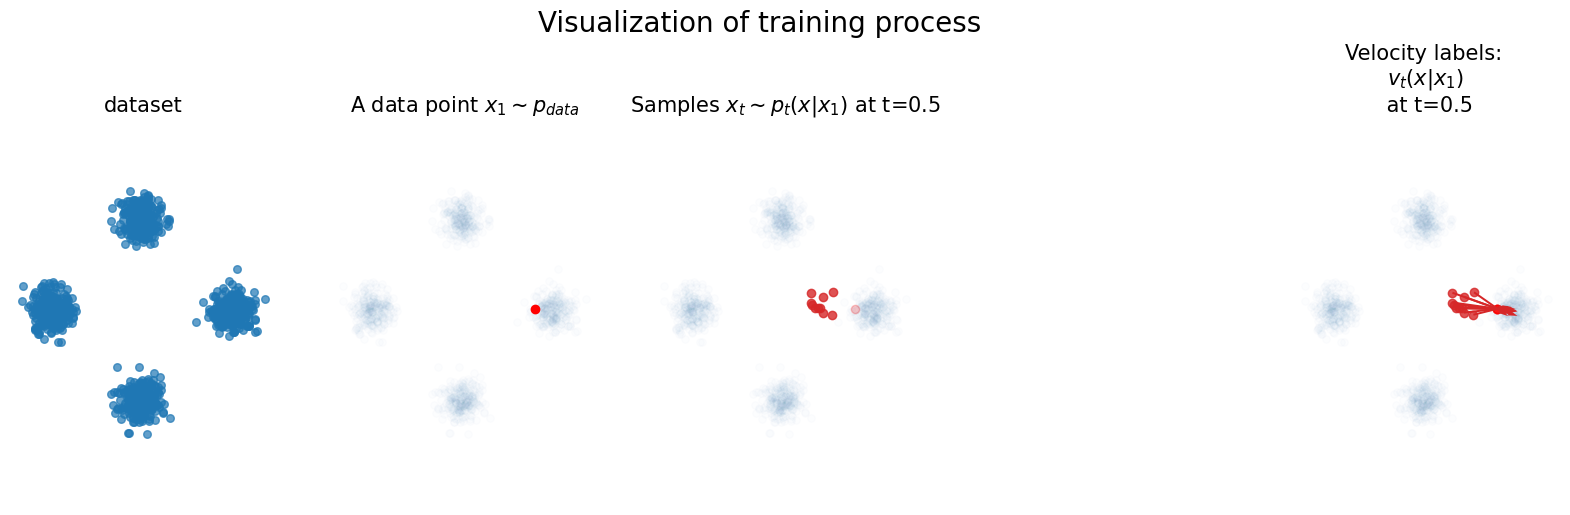

In [16]:
fig, axs = plt.subplots(1, 5, figsize=(5*4, 5))

x = ds.X[2:3]
t = 0.5

ds.add_blobs(axs[0])
axs[0].axis('off')
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(-10, 10)
axs[0].set_title(f'dataset', fontsize=15)
axs[0].axis('equal')

ds.add_blobs(axs[1], alpha=0.01)
axs[1].axis('off')
axs[1].set_xlim(-10, 10)
axs[1].set_ylim(-10, 10)
axs[1].set_title(f'A data point $x_1 \sim p_{{data}}$', fontsize=15)
axs[1].axis('equal')
axs[1].scatter(x[:, 0], x[:, 1], color='red', label='*')

ds.add_blobs(axs[2], alpha=0.01)
axs[2].axis('off')
axs[2].set_xlim(-10, 10)
axs[2].set_ylim(-10, 10)

n_samples = 10
axs[2].set_title(f'Samples $x_t \sim p_t(x|x_1)$ at t={t}', fontsize=15)
axs[2].axis('equal')
axs[2].scatter(x[:, 0], x[:, 1], color='red', label='*', alpha=0.2)
t_torch = torch.tensor([[t]]).repeat(n_samples, 1)
x = x.repeat(n_samples, 1)
x_t = model.sample_from_p_tx_x1(t_torch, x).detach().cpu()
axs[2].scatter(x_t[:, 0], x_t[:, 1], color='tab:red', label='*', alpha=0.8)

axs[3].axis('off')

ds.add_blobs(axs[4], alpha=0.01)
axs[4].axis('off')
axs[4].set_xlim(-10, 10)
axs[4].set_ylim(-10, 10)
axs[4].set_title(f'Velocity labels: \n' + r'$v_t(x|x_1)$' + f' \n at t={t}', fontsize=15)
axs[4].axis('equal')
axs[4].scatter(x[:, 0], x[:, 1], color='red', label='*', alpha=0.2)
axs[4].scatter(x_t[:, 0], x_t[:, 1], color='tab:red', label='*', alpha=0.8)
v_labels = model.velocity_conditioned_on_x1(t_torch, x_t, x).detach().cpu()
axs[4].quiver(x_t[:, 0], x_t[:, 1], v_labels[:, 0], v_labels[:, 1], color='tab:red', scale=20)

plt.suptitle('Visualization of training process', fontsize=20, y=1.1)
plt.show()

In [18]:
video = []
for t in torch.linspace(1, 0, 101):
    fig, axs = plt.subplots(1, 5, figsize=(5*4, 5))
    t = t.item()
    t_torch = torch.tensor([[t]]).repeat(n_samples, 1)
    x = ds.X[1:2]
    x = x.repeat(n_samples, 1)
    
    ds.add_blobs(axs[0])
    axs[0].axis('off')
    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)
    axs[0].set_title(f'dataset', fontsize=15)
    axs[0].axis('equal')

    ds.add_blobs(axs[1], alpha=0.01)
    axs[1].axis('off')
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)
    axs[1].set_title(f'A data point $x_1 \sim p_{{data}}$', fontsize=15)
    axs[1].axis('equal')
    axs[1].scatter(x[:, 0], x[:, 1], color='red', label='*')

    ds.add_blobs(axs[2], alpha=0.01)
    axs[2].axis('off')
    axs[2].set_xlim(-10, 10)
    axs[2].set_ylim(-10, 10)
    n_samples = 10
    axs[2].set_title(f'Samples $x_t \sim p_t(x|x_1)$ at t={t:.2f}', fontsize=15)
    axs[2].axis('equal')
    axs[2].scatter(x[:, 0], x[:, 1], color='red', label='*', alpha=0.2)
    x_t = model.sample_from_p_tx_x1(t_torch, x).detach().cpu()
    axs[2].scatter(x_t[:, 0], x_t[:, 1], color='tab:red', label='*', alpha=0.8)

    # ds.add_blobs(axs[3], alpha=0.01)
    axs[3].axis('off')
    # axs[3].set_xlim(-10, 10)
    # axs[3].set_ylim(-10, 10)
    # axs[3].set_title(f'Score labels: \n' + r'$\nabla_x log p_t(x|x_0)$ ' + f'at t={t:.2f}', fontsize=15)
    # axs[3].axis('equal')
    # axs[3].scatter(x[:, 0], x[:, 1], color='red', label='*', alpha=0.2)
    # axs[3].scatter(x_t[:, 0], x_t[:, 1], color='tab:red', label='*', alpha=0.8)
    # s_labels = model.score_conditioned_on_x1(t_torch, x_t, x).detach().cpu()
    # axs[3].quiver(x_t[:, 0], x_t[:, 1], s_labels[:, 0], s_labels[:, 1], color='tab:red', scale=20)

    ds.add_blobs(axs[4], alpha=0.01)
    axs[4].axis('off')
    axs[4].set_xlim(-10, 10)
    axs[4].set_ylim(-10, 10)
    axs[4].set_title(f'Velocity labels: \n' + r'$v_t(x|x_1)' + f' \n at t={t:.2f}', fontsize=15)
    axs[4].axis('equal')
    axs[4].scatter(x[:, 0], x[:, 1], color='red', label='*', alpha=0.2)
    axs[4].scatter(x_t[:, 0], x_t[:, 1], color='tab:red', label='*', alpha=0.8)
    v_labels = model.velocity_conditioned_on_x1(t_torch, x_t, x).detach().cpu()
    axs[4].quiver(x_t[:, 0], x_t[:, 1], v_labels[:, 0], v_labels[:, 1], color='tab:red', scale=20)

    plt.suptitle('Visualization of training process', fontsize=20, y=1.1)
    
    # Save the figure to a buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')  # Save to a buffer as a PNG image
    buf.seek(0)  # Rewind the buffer

    # Load the buffer into a PIL image and convert to NumPy array
    image = Image.open(buf)
    image_array = np.array(image)  # Convert to a NumPy array
    buf.close()  # Close the buffer
    plt.close()
    
    video.append(image_array)

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
C:\Users\21448\AppData\Local\Temp\ipykernel_4224\2467821260.py:20: SyntaxWarning: invalid escape sequence '\s'
  axs[1].set_title(f'A data point $x_1 \sim p_{{data}}$', fontsize=15)
C:\Users\21448\AppData\Local\Temp\ipykernel_4224\2467821260.py:29: SyntaxWarning: invalid escape sequence '\s'
  axs[2].set_title(f'Samples $x_t \sim p_t(x|x_1)$ at t={t:.2f}', fontsize=15)


In [19]:
display_video(video, framerate=20)